# Trust Scores applied to Iris

It is important to know when a machine learning classifier's predictions can be trusted. Relying on the classifier's (uncalibrated) prediction probabilities is not optimal and can be improved upon. *Trust scores* measure the agreement between the classifier and a modified nearest neighbor classifier on the test set. The trust score is the ratio between the distance of the test instance to the nearest class different from the predicted class and the distance to the predicted class. Higher scores correspond to more trustworthy predictions. A score of 1 would mean that the distance to the predicted class is the same as to another class.

The original paper on which the algorithm is based is called [To Trust Or Not To Trust A Classifier](https://arxiv.org/abs/1805.11783). Our implementation borrows heavily from https://github.com/google/TrustScore, as does the example notebook.

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from alibi.confidence import TrustScore

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Load and prepare Iris dataset

In [2]:
dataset = load_iris()

Scale data

In [3]:
dataset.data = (dataset.data - dataset.data.mean(axis=0)) / dataset.data.std(axis=0)

Define training and test set

In [4]:
idx = 140
X_train,y_train = dataset.data[:idx,:], dataset.target[:idx]
X_test, y_test = dataset.data[idx+1:,:], dataset.target[idx+1:]

## Fit model and make predictions

In [5]:
np.random.seed(0)
clf = LogisticRegression(solver='liblinear', multi_class='auto')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f'Predicted class: {y_pred}')

Predicted class: [2 2 2 2 2 2 2 2 2]


'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.


## Basic Trust Score Usage

### Initialise Trust Scores and fit on training data

The trust score algorithm builds [k-d trees](https://en.wikipedia.org/wiki/K-d_tree) for each class. The distance of the test instance to the $k$th nearest neighbor of each tree (or the average distance to the $k$th neighbor) can then be used to calculate the trust score. We can optionally filter out outliers in the training data before building the trees. The example below uses the *distance_knn* (`filter_type`) method to filter out the 5% (`alpha`) instances of each class with the highest distance to its 10th nearest neighbor (`k_filter`) in that class.

In [6]:
ts = TrustScore(k_filter=10,  # nb of neighbors used for kNN distance or probability to filter out outliers
                alpha=.05,  # target fraction of instances to filter out
                filter_type='distance_knn',  # filter method: None, 'distance_knn' or 'probability_knn'
                leaf_size=40,  # affects speed and memory to build KDTrees, memory scales with n_samples / leaf_size
                metric='euclidean',  # distance metric used for the KDTrees
                dist_filter_type='point')  # 'point' uses distance to k-nearest point
                                           # 'mean' uses average distance from the 1st to the kth nearest point

In [7]:
ts.fit(X_train, y_train, classes=3)  # classes = nb of prediction classes

### Calculate Trust Scores on test data

Since the trust score is the ratio between the distance of the test instance to the nearest class different from the predicted class and the distance to the predicted class, higher scores correspond to more trustworthy predictions. A score of 1 would mean that the distance to the predicted class is the same as to another class. The `score` method returns arrays with both the trust scores and the class labels of the closest not predicted class.

In [8]:
score, closest_class = ts.score(X_test, 
                                y_pred, k=2,  # kth nearest neighbor used 
                                              # to compute distances for each class
                                dist_type='point')  # 'point' or 'mean' distance option
print(f'Trust scores: {score}')
print(f'\nClosest not predicted class: {closest_class}')

Trust scores: [2.57427128 2.1630335  3.16294054 2.72584945 2.54174803 1.40287828
 1.94107306 2.06017254 2.17811215]

Closest not predicted class: [1 1 1 1 1 1 1 1 1]


## Comparison of Trust Scores with model prediction probabilities

Let's compare the prediction probabilities from the classifier with the trust scores for each prediction. The first use case checks whether trust scores are better than the model's prediction probabilities at identifying correctly classified examples, while the second use case does the same for incorrectly classified instances. 

First we need to set up a couple of helper functions.

* Define a function that handles model training and predictions for a simple logistic regression:

In [9]:
def run_lr(X_train, y_train, X_test):
    clf = LogisticRegression(solver='liblinear', multi_class='auto')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    probas = y_pred_proba[range(len(y_pred)), y_pred]  # probabilities of predicted class
    return y_pred, probas

* Define the function that generates the precision plots:

In [10]:
def plot_precision_curve(plot_title, 
                         percentiles, 
                         labels, 
                         final_tp, 
                         final_stderr, 
                         final_misclassification,
                         colors = ['blue', 'darkorange', 'brown', 'red', 'purple']):
    
    plt.title(plot_title, fontsize=18)
    colors = colors + list(cm.rainbow(np.linspace(0, 1, len(final_tp))))
    plt.xlabel("Percentile", fontsize=14)
    plt.ylabel("Precision", fontsize=14)
    
    for i, label in enumerate(labels):
        ls = "--" if ("Model" in label) else "-"
        plt.plot(percentiles, final_tp[i], ls, c=colors[i], label=label)
        plt.fill_between(percentiles, 
                         final_tp[i] - final_stderr[i],
                         final_tp[i] + final_stderr[i],
                         color=colors[i],
                         alpha=.1)
    
    if 0. in percentiles:
        plt.legend(loc="lower right", fontsize=14)
    else:
        plt.legend(loc="upper left", fontsize=14)
    model_acc = 100 * (1 - final_misclassification)
    plt.axvline(x=model_acc, linestyle="dotted", color="black")
    plt.show()

* The function below trains the model on a number of folds, makes predictions, calculates the trust scores, and generates the precision curves to compare the trust scores with the model prediction probabilities:

In [11]:
def run_precision_plt(X, y, nfolds, percentiles, run_model, test_size=.5, 
                      plt_title="", plt_names=[], predict_correct=True, classes=3):
    
    def stderr(L):
        return np.std(L) / np.sqrt(len(L))
    
    all_tp = [[[] for p in percentiles] for _ in plt_names]
    misclassifications = []
    mult = 1 if predict_correct else -1
    
    folds = StratifiedShuffleSplit(n_splits=nfolds, test_size=test_size, random_state=0)
    for train_idx, test_idx in folds.split(X, y):
        # create train and test folds, train model and make predictions
        X_train, y_train = X[train_idx, :], y[train_idx]
        X_test, y_test = X[test_idx, :], y[test_idx]
        y_pred, probas = run_model(X_train, y_train, X_test)
        # target points are the correctly classified points
        target_points = np.where(y_pred == y_test)[0] if predict_correct else np.where(y_pred != y_test)[0]
        final_curves = [probas]
        # calculate trust scores
        ts = TrustScore()
        ts.fit(X_train, y_train, classes=classes)
        scores, _ = ts.score(X_test, y_pred)
        final_curves.append(scores)  # contains prediction probabilities and trust scores
        # check where prediction probabilities and trust scores are above a certain percentage level
        for p, perc in enumerate(percentiles):
            high_proba = [np.where(mult * curve >= np.percentile(mult * curve, perc))[0] for curve in final_curves]
            if 0 in map(len, high_proba):
                continue
            # calculate fraction of values above percentage level that are correctly (or incorrectly) classified
            tp = [len(np.intersect1d(hp, target_points)) / (1. * len(hp)) for hp in high_proba]
            for i in range(len(plt_names)):
                all_tp[i][p].append(tp[i])  # for each percentile, store fraction of values above cutoff value
        misclassifications.append(len(target_points) / (1. * len(X_test)))
    
    # average over folds for each percentile
    final_tp = [[] for _ in plt_names]
    final_stderr = [[] for _ in plt_names]
    for p, perc in enumerate(percentiles):
        for i in range(len(plt_names)):
            final_tp[i].append(np.mean(all_tp[i][p]))
            final_stderr[i].append(stderr(all_tp[i][p]))

    for i in range(len(all_tp)):
        final_tp[i] = np.array(final_tp[i])
        final_stderr[i] = np.array(final_stderr[i])

    final_misclassification = np.mean(misclassifications)
    
    # create plot
    plot_precision_curve(plt_title, percentiles, plt_names, final_tp, final_stderr, final_misclassification)

### Detect correctly classified examples

The x-axis on the plot below shows the percentiles for the model prediction probabilities of the predicted class for each instance and for the trust scores. The y-axis represents the precision for each percentile. For each percentile level, we take the test examples whose trust score is above that percentile level and plot the percentage of those points that were correctly classified by the classifier. We do the same with the classifier's own model confidence (i.e. softmax probabilities). For example, at percentile level 80, we take the top 20% scoring test examples based on the trust score and plot the percentage of those points that were correctly classified. We also plot the top 20% scoring test examples based on model probabilities and plot the percentage of those that were correctly classified. The vertical dotted line is the error of the logistic regression classifier. The plots are an average over 10 folds of the dataset with 50% of the data kept for the test set.

The *Trust Score* and *Model Confidence* curves then show that the model precision is typically higher when using the trust scores to rank the predictions compared to the model prediction probabilities.

In [12]:
X = dataset.data
y = dataset.target
percentiles = [0 + 0.5 * i for i in range(200)]
nfolds = 10
plt_names = ['Model Confidence', 'Trust Score']
plt_title = 'Iris -- Logistic Regression -- Predict Correct'

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its

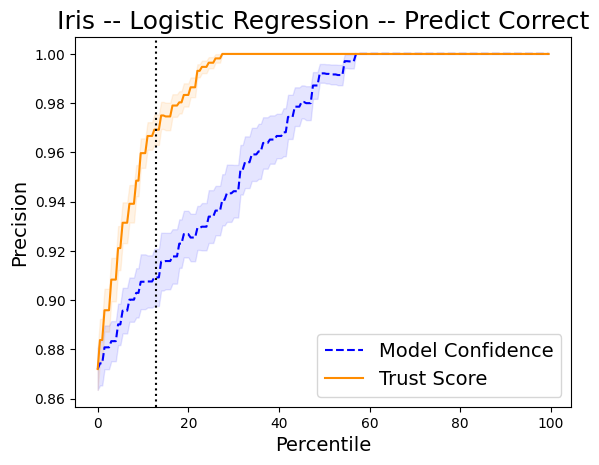

In [13]:
run_precision_plt(X, y, nfolds, percentiles, run_lr, plt_title=plt_title, 
                  plt_names=plt_names, predict_correct=True)

### Detect incorrectly classified examples

By taking the *negative of the prediction probabilities and trust scores*, we can also see on the plot below how the trust scores compare to the model predictions for incorrectly classified instances. The vertical dotted line is the accuracy of the logistic regression classifier. The plot shows the precision of identifying incorrectly classified instances. Higher is obviously better.

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its

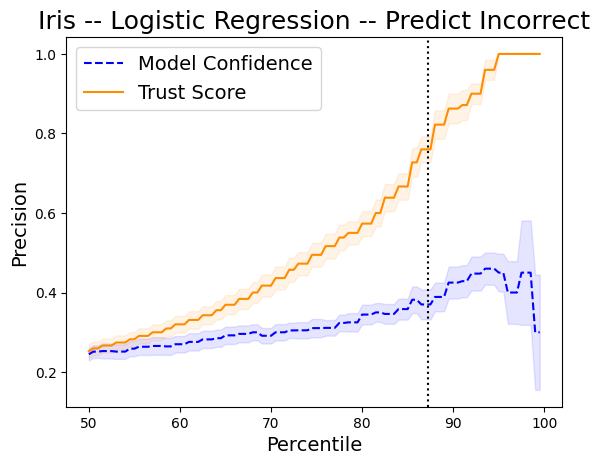

In [14]:
percentiles = [50 + 0.5 * i for i in range(100)]
plt_title = 'Iris -- Logistic Regression -- Predict Incorrect'
run_precision_plt(X, y, nfolds, percentiles, run_lr, plt_title=plt_title, 
                  plt_names=plt_names, predict_correct=False)